# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import vaep
import vaep.analyzers
import vaep.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
vaep.plotting.make_large_descriptors(fontsize)


logger = vaep.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "QRILC"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = vaep.nb.get_params(args, globals=globals())
args = vaep.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = vaep.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'QRILC',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = vaep.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

vaep.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


vaep.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


vaep.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups      
Sample_152  O43300                 15.751
Sample_206  I3L3J8;P14415          16.658
Sample_085  Q14894                 15.507
Sample_048  Q8IWV2                 16.342
Sample_147  H7BZT7;P10768;X6RA14   15.521
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = vaep.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[vaep.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = vaep.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by QRILC: runs/alzheimer_study/preds/pred_real_na_QRILC.csv


Sample ID   protein groups               
Sample_007  C9J4G9;C9J539;P16278;P16278-3   11.324
Sample_018  Q6UWP8                           6.198
Sample_182  P81605                          14.878
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 14.651
            A0A075B6Q5                 12.261
            A0A075B6R2                 12.338
            A0A075B6S5                 12.700
            A0A087WSY4                 12.024
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   13.186
            Q9UI40;Q9UI40-2            11.748
            Q9UIW2                     12.477
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.276
            Q9UP79                     12.536
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,12.286,15.050,16.842,19.863,13.631,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,14.209,19.067,...,15.528,15.576,13.076,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,13.504,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,14.961,17.705,17.039,11.900,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,10.498,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,13.010,15.345,17.084,18.708,14.249,19.433,8.786,9.066
Sample_207,15.739,16.877,15.469,16.898,14.884,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,14.651,...,16.012,15.178,11.789,15.050,16.842,19.863,14.649,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,14.032,19.067,16.188,...,15.528,15.576,13.871,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,13.222,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,11.946,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.837,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,13.200,15.345,17.084,18.708,14.249,19.433,11.965,13.075
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 341.69it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.42it/s]

100%|██████████| 2/2 [00:00<00:00,  6.39it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.74it/s]

100%|██████████| 3/3 [00:00<00:00,  4.14it/s]

100%|██████████| 3/3 [00:00<00:00,  4.32it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  3.94it/s]

 75%|███████▌  | 3/4 [00:01<00:00,  2.79it/s]

100%|██████████| 4/4 [00:01<00:00,  2.70it/s]

100%|██████████| 4/4 [00:01<00:00,  2.85it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  6.69it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.45it/s]

 80%|████████  | 4/5 [00:00<00:00,  3.65it/s]

100%|██████████| 5/5 [00:01<00:00,  3.50it/s]

100%|██████████| 5/5 [00:01<00:00,  3.86it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  4.10it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.13it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.90it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.92it/s]

100%|██████████| 6/6 [00:02<00:00,  2.66it/s]

100%|██████████| 6/6 [00:02<00:00,  2.86it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  3.57it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.30it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.70it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.56it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.57it/s]

100%|██████████| 7/7 [00:02<00:00,  2.54it/s]

100%|██████████| 7/7 [00:02<00:00,  2.69it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  5.13it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.99it/s]

 50%|█████     | 4/8 [00:01<00:01,  3.10it/s]

 62%|██████▎   | 5/8 [00:01<00:01,  3.00it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  2.94it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.58it/s]

100%|██████████| 8/8 [00:02<00:00,  2.48it/s]

100%|██████████| 8/8 [00:02<00:00,  2.86it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  3.74it/s]

 33%|███▎      | 3/9 [00:01<00:02,  2.48it/s]

 44%|████▍     | 4/9 [00:01<00:02,  2.14it/s]

 56%|█████▌    | 5/9 [00:02<00:01,  2.21it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.34it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.47it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  2.55it/s]

100%|██████████| 9/9 [00:03<00:00,  2.70it/s]

100%|██████████| 9/9 [00:03<00:00,  2.54it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  5.67it/s]

 30%|███       | 3/10 [00:00<00:01,  3.77it/s]

 40%|████      | 4/10 [00:01<00:01,  3.24it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.21it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.29it/s]

 70%|███████   | 7/10 [00:02<00:00,  3.11it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.99it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.00it/s]

100%|██████████| 10/10 [00:03<00:00,  3.02it/s]

100%|██████████| 10/10 [00:03<00:00,  3.21it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  6.99it/s]

 27%|██▋       | 3/11 [00:00<00:01,  4.66it/s]

 36%|███▋      | 4/11 [00:00<00:01,  3.56it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.28it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.21it/s]

 64%|██████▎   | 7/11 [00:01<00:01,  3.17it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.49it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.31it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.15it/s]

100%|██████████| 11/11 [00:04<00:00,  2.11it/s]

100%|██████████| 11/11 [00:04<00:00,  2.67it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.11it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.29it/s]

 33%|███▎      | 4/12 [00:01<00:03,  2.63it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.37it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.08it/s]

 58%|█████▊    | 7/12 [00:02<00:02,  2.19it/s]

 67%|██████▋   | 8/12 [00:03<00:01,  2.18it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.32it/s]

 83%|████████▎ | 10/12 [00:04<00:00,  2.41it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  2.36it/s]

100%|██████████| 12/12 [00:04<00:00,  2.39it/s]

100%|██████████| 12/12 [00:04<00:00,  2.44it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:03,  3.21it/s]

 23%|██▎       | 3/13 [00:01<00:03,  2.72it/s]

 31%|███       | 4/13 [00:01<00:03,  2.40it/s]

 38%|███▊      | 5/13 [00:01<00:03,  2.49it/s]

 46%|████▌     | 6/13 [00:02<00:02,  2.46it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.62it/s]

 62%|██████▏   | 8/13 [00:03<00:01,  2.62it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.46it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.48it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.47it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.58it/s]

100%|██████████| 13/13 [00:05<00:00,  2.59it/s]

100%|██████████| 13/13 [00:05<00:00,  2.56it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  4.31it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.00it/s]

 29%|██▊       | 4/14 [00:01<00:04,  2.44it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.35it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.46it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.43it/s]

 57%|█████▋    | 8/14 [00:03<00:02,  2.45it/s]

 64%|██████▍   | 9/14 [00:03<00:01,  2.54it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.63it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.59it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.74it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.77it/s]

100%|██████████| 14/14 [00:05<00:00,  2.86it/s]

100%|██████████| 14/14 [00:05<00:00,  2.68it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:03,  3.56it/s]

 20%|██        | 3/15 [00:01<00:05,  2.37it/s]

 27%|██▋       | 4/15 [00:01<00:04,  2.25it/s]

 33%|███▎      | 5/15 [00:02<00:04,  2.31it/s]

 40%|████      | 6/15 [00:02<00:03,  2.40it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.43it/s]

 53%|█████▎    | 8/15 [00:03<00:02,  2.44it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.54it/s]

 67%|██████▋   | 10/15 [00:04<00:01,  2.57it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.63it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.67it/s]

 87%|████████▋ | 13/15 [00:05<00:00,  2.68it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.68it/s]

100%|██████████| 15/15 [00:05<00:00,  2.57it/s]

100%|██████████| 15/15 [00:05<00:00,  2.55it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.006 0.008      0.061 0.025          0.736 0.369       0.109   
2             0.005 0.005      0.068 0.026          0.758 0.090       0.709   
3             0.005 0.005      0.052 0.016          0.755 0.088       0.712   
4             0.004 0.003      0.060 0.020          0.789 0.097       0.778   
5             0.006 0.006      0.068 0.025          0.779 0.088       0.778   
6             0.004 0.003      0.051 0.013          0.782 0.089       0.793   
7             0.006 0.005      0.062 0.021          0.839 0.082       0.819   
8             0.004 0.000      0.055 0.018          0.842 0.076       0.821   
9             0.005 0.005      0.057 0.021          0.833 0.074       0.819   
10            0.006 0.004      0.069 0.026          0.828 0.072       0.812   
11            0.004 0.003      0.049 0.012          0.828 0.075       0.808   
12            0.004 0.001      0.048 0.007          0.823 0.075       0.809   
13            0.004 0.002      0.054 0.018          0.823 0.075       0.807   
14            0.005 0.004      0.064 0.022          0.819 0.087       0.811   
15            0.006 0.005      0.076 0.033          0.817 0.089       0.810   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.084   0.182 0.129                  0.547 0.040        0.855   
2          0.092   0.726 0.060                  0.768 0.048        0.856   
3          0.087   0.728 0.066                  0.769 0.053        0.857   
4          0.095   0.779 0.072                  0.810 0.062        0.894   
5          0.091   0.774 0.065                  0.806 0.056        0.898   
6          0.096   0.783 0.071                  0.814 0.062        0.897   
7          0.101   0.824 0.071                  0.850 0.060        0.912   
8          0.102   0.827 0.069                  0.853 0.058        0.911   
9          0.093   0.822 0.065                  0.848 0.055        0.912   
10         0.099   0.817 0.069                  0.844 0.057        0.910   
11         0.098   0.815 0.070                  0.842 0.058        0.910   
12         0.096   0.813 0.069                  0.840 0.057        0.908   
13         0.094   0.811 0.066                  0.839 0.055        0.907   
14         0.095   0.811 0.070                  0.838 0.060        0.909   
15         0.097   0.809 0.071                  0.836 0.060        0.907   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.064                  0.825 0.089        210.000 0.000  
2          0.060                  0.833 0.067        210.000 0.000  
3          0.059                  0.839 0.066        210.000 0.000  
4          0.053                  0.878 0.060        210.000 0.000  
5          0.049                  0.883 0.052        210.000 0.000  
6          0.050                  0.882 0.054        210.000 0.000  
7          0.053                  0.898 0.056        210.000 0.000  
8          0.053                  0.898 0.057        210.000 0.000  
9          0.053                  0.900 0.056        210.000 0.000  
10         0.054                  0.898 0.056        210.000 0.000  
11         0.055                  0.897 0.058        210.000 0.000  
12         0.055                  0.895 0.059        210.000 0.000  
13         0.056                  0.892 0.060        210.000 0.000  
14         0.054                  0.898 0.056        210.000 0.000  
15         0.053                  0.895 0.055 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 79.72it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  3.19it/s]

100%|██████████| 2/2 [00:00<00:00,  3.07it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  3.32it/s]

100%|██████████| 3/3 [00:01<00:00,  2.44it/s]

100%|██████████| 3/3 [00:01<00:00,  2.57it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  3.00it/s]

 75%|███████▌  | 3/4 [00:01<00:00,  1.98it/s]

100%|██████████| 4/4 [00:01<00:00,  1.90it/s]

100%|██████████| 4/4 [00:01<00:00,  2.01it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:01,  2.51it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.77it/s]

 80%|████████  | 4/5 [00:02<00:00,  1.63it/s]

100%|██████████| 5/5 [00:02<00:00,  1.70it/s]

100%|██████████| 5/5 [00:02<00:00,  1.76it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  4.17it/s]

 50%|█████     | 3/6 [00:00<00:01,  2.97it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.76it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.67it/s]

100%|██████████| 6/6 [00:02<00:00,  2.68it/s]

100%|██████████| 6/6 [00:02<00:00,  2.82it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  3.20it/s]

 43%|████▎     | 3/7 [00:01<00:01,  2.44it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.22it/s]

 71%|███████▏  | 5/7 [00:02<00:00,  2.16it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.08it/s]

100%|██████████| 7/7 [00:03<00:00,  2.19it/s]

100%|██████████| 7/7 [00:03<00:00,  2.24it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  3.52it/s]

 38%|███▊      | 3/8 [00:01<00:02,  2.50it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.08it/s]

 62%|██████▎   | 5/8 [00:02<00:01,  1.91it/s]

 75%|███████▌  | 6/8 [00:02<00:00,  2.01it/s]

 88%|████████▊ | 7/8 [00:03<00:00,  1.98it/s]

100%|██████████| 8/8 [00:03<00:00,  2.04it/s]

100%|██████████| 8/8 [00:03<00:00,  2.11it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  5.90it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.18it/s]

 44%|████▍     | 4/9 [00:01<00:02,  2.40it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.23it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.22it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.04it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  2.22it/s]

100%|██████████| 9/9 [00:03<00:00,  2.29it/s]

100%|██████████| 9/9 [00:03<00:00,  2.40it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  5.29it/s]

 30%|███       | 3/10 [00:01<00:02,  2.63it/s]

 40%|████      | 4/10 [00:01<00:02,  2.45it/s]

 50%|█████     | 5/10 [00:02<00:02,  2.13it/s]

 60%|██████    | 6/10 [00:02<00:02,  1.86it/s]

 70%|███████   | 7/10 [00:03<00:01,  2.00it/s]

 80%|████████  | 8/10 [00:03<00:00,  2.15it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.27it/s]

100%|██████████| 10/10 [00:04<00:00,  2.34it/s]

100%|██████████| 10/10 [00:04<00:00,  2.31it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  5.53it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.82it/s]

 36%|███▋      | 4/11 [00:01<00:02,  2.57it/s]

 45%|████▌     | 5/11 [00:02<00:02,  2.03it/s]

 55%|█████▍    | 6/11 [00:02<00:02,  1.99it/s]

 64%|██████▎   | 7/11 [00:03<00:02,  1.99it/s]

 73%|███████▎  | 8/11 [00:03<00:01,  2.14it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.31it/s]

 91%|█████████ | 10/11 [00:04<00:00,  2.38it/s]

100%|██████████| 11/11 [00:04<00:00,  2.43it/s]

100%|██████████| 11/11 [00:04<00:00,  2.40it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.21it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.90it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.12it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.40it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.10it/s]

 58%|█████▊    | 7/12 [00:03<00:02,  1.88it/s]

 67%|██████▋   | 8/12 [00:03<00:02,  1.87it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.02it/s]

 83%|████████▎ | 10/12 [00:04<00:00,  2.14it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  2.14it/s]

100%|██████████| 12/12 [00:05<00:00,  2.24it/s]

100%|██████████| 12/12 [00:05<00:00,  2.30it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  5.08it/s]

 23%|██▎       | 3/13 [00:00<00:03,  3.27it/s]

 31%|███       | 4/13 [00:01<00:03,  2.97it/s]

 38%|███▊      | 5/13 [00:01<00:03,  2.49it/s]

 46%|████▌     | 6/13 [00:02<00:03,  2.18it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.13it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  2.09it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.13it/s]

 77%|███████▋  | 10/13 [00:04<00:01,  2.29it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.36it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.45it/s]

100%|██████████| 13/13 [00:05<00:00,  2.48it/s]

100%|██████████| 13/13 [00:05<00:00,  2.45it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.08it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.56it/s]

 29%|██▊       | 4/14 [00:01<00:03,  3.27it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.05it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.40it/s]

 50%|█████     | 7/14 [00:02<00:03,  2.17it/s]

 57%|█████▋    | 8/14 [00:03<00:02,  2.05it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.08it/s]

 71%|███████▏  | 10/14 [00:04<00:01,  2.11it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.21it/s]

 86%|████████▌ | 12/14 [00:05<00:00,  2.03it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  2.11it/s]

100%|██████████| 14/14 [00:06<00:00,  2.04it/s]

100%|██████████| 14/14 [00:06<00:00,  2.30it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.81it/s]

 20%|██        | 3/15 [00:00<00:02,  4.16it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.36it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.54it/s]

 40%|████      | 6/15 [00:02<00:04,  2.17it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.09it/s]

 53%|█████▎    | 8/15 [00:03<00:03,  2.14it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.20it/s]

 67%|██████▋   | 10/15 [00:04<00:02,  2.02it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.07it/s]

 80%|████████  | 12/15 [00:05<00:01,  2.12it/s]

 87%|████████▋ | 13/15 [00:05<00:00,  2.19it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.29it/s]

100%|██████████| 15/15 [00:06<00:00,  2.29it/s]

100%|██████████| 15/15 [00:06<00:00,  2.36it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.003      0.054 0.018          0.826 0.274       0.144   
2             0.005 0.004      0.055 0.022          0.731 0.089       0.632   
3             0.005 0.004      0.060 0.021          0.751 0.069       0.690   
4             0.004 0.003      0.052 0.024          0.758 0.083       0.754   
5             0.005 0.004      0.059 0.024          0.736 0.091       0.710   
6             0.005 0.004      0.063 0.027          0.798 0.078       0.753   
7             0.004 0.002      0.052 0.019          0.796 0.080       0.766   
8             0.004 0.003      0.050 0.014          0.809 0.084       0.801   
9             0.005 0.003      0.056 0.018          0.805 0.091       0.794   
10            0.006 0.004      0.055 0.020          0.803 0.092       0.798   
11            0.004 0.002      0.053 0.014          0.849 0.081       0.839   
12            0.004 0.002      0.055 0.015          0.845 0.087       0.842   
13            0.005 0.003      0.059 0.021          0.835 0.086       0.842   
14            0.005 0.003      0.054 0.016          0.836 0.083       0.842   
15            0.007 0.005      0.077 0.034          0.825 0.082       0.847   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.087   0.237 0.127                  0.564 0.044        0.853   
2          0.113   0.672 0.081                  0.729 0.059        0.792   
3          0.113   0.714 0.075                  0.761 0.056        0.862   
4          0.115   0.750 0.076                  0.787 0.060        0.869   
5          0.119   0.716 0.082                  0.759 0.064        0.870   
6          0.101   0.770 0.067                  0.805 0.055        0.881   
7          0.099   0.776 0.069                  0.810 0.058        0.882   
8          0.097   0.801 0.069                  0.830 0.059        0.906   
9          0.101   0.794 0.070                  0.824 0.059        0.906   
10         0.108   0.795 0.075                  0.825 0.064        0.904   
11         0.088   0.840 0.066                  0.863 0.055        0.918   
12         0.090   0.839 0.067                  0.862 0.057        0.919   
13         0.089   0.835 0.069                  0.859 0.059        0.917   
14         0.092   0.835 0.068                  0.859 0.059        0.916   
15         0.096   0.832 0.066                  0.856 0.057        0.915   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.063                  0.825 0.088        210.000 0.000  
2          0.068                  0.758 0.086        210.000 0.000  
3          0.055                  0.841 0.064        210.000 0.000  
4          0.057                  0.853 0.064        210.000 0.000  
5          0.056                  0.844 0.070        210.000 0.000  
6          0.049                  0.854 0.063        210.000 0.000  
7          0.048                  0.858 0.062        210.000 0.000  
8          0.046                  0.874 0.063        210.000 0.000  
9          0.046                  0.879 0.060        210.000 0.000  
10         0.046                  0.874 0.063        210.000 0.000  
11         0.046                  0.902 0.051        210.000 0.000  
12         0.046                  0.902 0.053        210.000 0.000  
13         0.047                  0.900 0.054        210.000 0.000  
14         0.047                  0.899 0.054        210.000 0.000  
15         0.047                  0.900 0.052 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 982.04it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 26.17it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 19.03it/s]

100%|██████████| 3/3 [00:00<00:00, 18.70it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 17.17it/s]

100%|██████████| 4/4 [00:00<00:00, 15.17it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00, 19.61it/s]

 80%|████████  | 4/5 [00:00<00:00, 11.12it/s]

100%|██████████| 5/5 [00:00<00:00, 10.56it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 17.14it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 14.18it/s]

100%|██████████| 6/6 [00:00<00:00, 14.26it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00, 18.62it/s]

 57%|█████▋    | 4/7 [00:00<00:00, 17.05it/s]

 86%|████████▌ | 6/7 [00:00<00:00, 15.70it/s]

100%|██████████| 7/7 [00:00<00:00, 16.02it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00, 15.90it/s]

 50%|█████     | 4/8 [00:00<00:00, 13.01it/s]

 75%|███████▌  | 6/8 [00:00<00:00, 11.80it/s]

100%|██████████| 8/8 [00:00<00:00, 11.97it/s]

100%|██████████| 8/8 [00:00<00:00, 12.24it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 20.16it/s]

 67%|██████▋   | 6/9 [00:00<00:00, 14.39it/s]

 89%|████████▉ | 8/9 [00:00<00:00, 14.06it/s]

100%|██████████| 9/9 [00:00<00:00, 14.27it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 17.78it/s]

 50%|█████     | 5/10 [00:00<00:00, 13.32it/s]

 70%|███████   | 7/10 [00:00<00:00, 13.67it/s]

 90%|█████████ | 9/10 [00:00<00:00, 13.82it/s]

100%|██████████| 10/10 [00:00<00:00, 13.82it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00, 18.43it/s]

 36%|███▋      | 4/11 [00:00<00:00, 11.65it/s]

 55%|█████▍    | 6/11 [00:00<00:00,  9.29it/s]

 73%|███████▎  | 8/11 [00:00<00:00,  8.20it/s]

 82%|████████▏ | 9/11 [00:00<00:00,  8.54it/s]

 91%|█████████ | 10/11 [00:01<00:00,  8.74it/s]

100%|██████████| 11/11 [00:01<00:00,  8.90it/s]

100%|██████████| 11/11 [00:01<00:00,  9.23it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 19.06it/s]

 42%|████▏     | 5/12 [00:00<00:00, 13.91it/s]

 58%|█████▊    | 7/12 [00:00<00:00, 12.15it/s]

 75%|███████▌  | 9/12 [00:00<00:00, 11.61it/s]

 92%|█████████▏| 11/12 [00:00<00:00, 10.57it/s]

100%|██████████| 12/12 [00:01<00:00, 11.71it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 19.54it/s]

 38%|███▊      | 5/13 [00:00<00:00, 13.31it/s]

 54%|█████▍    | 7/13 [00:00<00:00, 11.05it/s]

 69%|██████▉   | 9/13 [00:00<00:00, 10.66it/s]

 85%|████████▍ | 11/13 [00:00<00:00, 11.27it/s]

100%|██████████| 13/13 [00:01<00:00, 11.63it/s]

100%|██████████| 13/13 [00:01<00:00, 11.82it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:00, 18.64it/s]

 29%|██▊       | 4/14 [00:00<00:00, 10.67it/s]

 43%|████▎     | 6/14 [00:00<00:00,  8.98it/s]

 57%|█████▋    | 8/14 [00:00<00:00,  8.33it/s]

 64%|██████▍   | 9/14 [00:00<00:00,  8.45it/s]

 71%|███████▏  | 10/14 [00:01<00:00,  8.59it/s]

 86%|████████▌ | 12/14 [00:01<00:00,  9.24it/s]

 93%|█████████▎| 13/14 [00:01<00:00,  9.15it/s]

100%|██████████| 14/14 [00:01<00:00,  9.42it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 18.66it/s]

 33%|███▎      | 5/15 [00:00<00:00, 14.13it/s]

 47%|████▋     | 7/15 [00:00<00:00, 11.95it/s]

 60%|██████    | 9/15 [00:00<00:00, 11.16it/s]

 73%|███████▎  | 11/15 [00:00<00:00, 11.03it/s]

 87%|████████▋ | 13/15 [00:01<00:00, 11.49it/s]

100%|██████████| 15/15 [00:01<00:00, 12.22it/s]

100%|██████████| 15/15 [00:01<00:00, 12.17it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.003      0.052 0.017          0.333 0.460       0.023   
2             0.006 0.006      0.079 0.033          0.601 0.115       0.415   
3             0.006 0.005      0.076 0.032          0.631 0.125       0.462   
4             0.006 0.004      0.071 0.027          0.592 0.108       0.457   
5             0.004 0.003      0.059 0.022          0.575 0.106       0.456   
6             0.004 0.003      0.065 0.029          0.569 0.113       0.452   
7             0.004 0.002      0.052 0.017          0.600 0.089       0.519   
8             0.004 0.001      0.050 0.012          0.590 0.085       0.539   
9             0.005 0.003      0.070 0.029          0.604 0.096       0.521   
10            0.006 0.007      0.065 0.029          0.595 0.107       0.506   
11            0.007 0.008      0.066 0.033          0.603 0.116       0.495   
12            0.006 0.005      0.082 0.042          0.596 0.119       0.488   
13            0.005 0.003      0.064 0.024          0.607 0.123       0.497   
14            0.006 0.005      0.067 0.029          0.604 0.108       0.544   
15            0.006 0.005      0.069 0.030          0.596 0.108       0.542   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.033   0.043 0.060                  0.509 0.017        0.710   
2          0.121   0.484 0.108                  0.607 0.066        0.685   
3          0.113   0.525 0.093                  0.628 0.066        0.700   
4          0.109   0.509 0.087                  0.610 0.063        0.697   
5          0.114   0.502 0.088                  0.602 0.065        0.687   
6          0.117   0.497 0.096                  0.599 0.072        0.680   
7          0.120   0.550 0.088                  0.632 0.062        0.680   
8          0.115   0.559 0.089                  0.634 0.062        0.680   
9          0.127   0.552 0.099                  0.636 0.065        0.678   
10         0.118   0.540 0.094                  0.625 0.067        0.673   
11         0.126   0.535 0.102                  0.626 0.071        0.670   
12         0.119   0.529 0.100                  0.621 0.071        0.661   
13         0.112   0.539 0.097                  0.626 0.071        0.678   
14         0.114   0.566 0.090                  0.639 0.067        0.725   
15         0.120   0.561 0.097                  0.635 0.073        0.723   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.056                  0.667 0.073        210.000 0.000  
2          0.072                  0.639 0.073        210.000 0.000  
3          0.084                  0.658 0.085        210.000 0.000  
4          0.085                  0.648 0.088        210.000 0.000  
5          0.085                  0.636 0.087        210.000 0.000  
6          0.085                  0.629 0.086        210.000 0.000  
7          0.084                  0.626 0.084        210.000 0.000  
8          0.086                  0.632 0.082        210.000 0.000  
9          0.085                  0.625 0.084        210.000 0.000  
10         0.082                  0.620 0.083        210.000 0.000  
11         0.086                  0.628 0.085        210.000 0.000  
12         0.082                  0.623 0.083        210.000 0.000  
13         0.082                  0.644 0.087        210.000 0.000  
14         0.079                  0.680 0.093        210.000 0.000  
15         0.077                  0.676 0.094 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,15,15,11
score_time,15,15,12
test_precision,8,11,3
test_recall,8,15,14
test_f1,8,11,14
test_balanced_accuracy,8,11,14
test_roc_auc,9,12,14
test_average_precision,9,12,14
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_ald_full, fname)

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:02,  3.65it/s]

 25%|██▌       | 3/12 [00:01<00:03,  2.47it/s]

 33%|███▎      | 4/12 [00:01<00:03,  2.05it/s]

 42%|████▏     | 5/12 [00:02<00:03,  1.97it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.11it/s]

 58%|█████▊    | 7/12 [00:03<00:02,  2.26it/s]

 67%|██████▋   | 8/12 [00:03<00:01,  2.32it/s]

 75%|███████▌  | 9/12 [00:04<00:01,  1.99it/s]

 83%|████████▎ | 10/12 [00:04<00:01,  1.85it/s]

 92%|█████████▏| 11/12 [00:05<00:00,  1.81it/s]

100%|██████████| 12/12 [00:05<00:00,  1.81it/s]

100%|██████████| 12/12 [00:05<00:00,  2.02it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 11.97it/s]

 36%|███▌      | 5/14 [00:00<00:00, 10.09it/s]

 50%|█████     | 7/14 [00:00<00:00,  8.87it/s]

 57%|█████▋    | 8/14 [00:00<00:00,  8.48it/s]

 64%|██████▍   | 9/14 [00:00<00:00,  8.65it/s]

 71%|███████▏  | 10/14 [00:01<00:00,  8.25it/s]

 79%|███████▊  | 11/14 [00:01<00:00,  7.30it/s]

 86%|████████▌ | 12/14 [00:01<00:00,  7.58it/s]

 93%|█████████▎| 13/14 [00:01<00:00,  7.84it/s]

100%|██████████| 14/14 [00:01<00:00,  7.40it/s]

100%|██████████| 14/14 [00:01<00:00,  8.21it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  5.51it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.36it/s]

 44%|████▍     | 4/9 [00:00<00:01,  3.75it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.62it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.29it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.06it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  2.18it/s]

100%|██████████| 9/9 [00:03<00:00,  2.08it/s]

100%|██████████| 9/9 [00:03<00:00,  2.46it/s]

### ROC-AUC on test split

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve.pdf


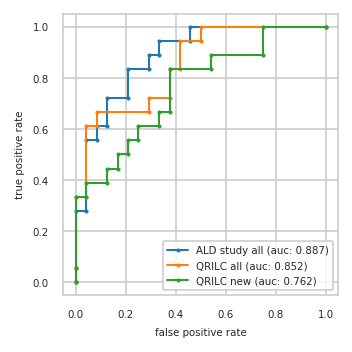

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       QRILC all       QRILC new      
             fpr   tpr       fpr   tpr       fpr   tpr
0          0.000 0.000     0.000 0.000     0.000 0.000
1          0.000 0.056     0.000 0.056     0.000 0.056
2          0.000 0.278     0.000 0.333     0.000 0.333
3          0.042 0.278     0.042 0.333     0.042 0.333
4          0.042 0.556     0.042 0.611     0.042 0.389
5          0.083 0.556     0.083 0.611     0.125 0.389
6          0.083 0.611     0.083 0.667     0.125 0.444
7          0.125 0.611     0.292 0.667     0.167 0.444
8          0.125 0.722     0.292 0.722     0.167 0.500
9          0.208 0.722     0.375 0.722     0.208 0.500
10         0.208 0.833     0.375 0.833     0.208 0.556
11         0.292 0.833     0.417 0.833     0.250 0.556
12         0.292 0.889     0.417 0.944     0.250 0.611
13         0.333 0.889     0.500 0.944     0.333 0.611
14         0.333 0.944     0.500 1.000     0.333 0.667
15         0.458 0.944     1.000 1.000     0.375 0.667
16         0.458 1.000       NaN   NaN     0.375 0.833
17         1.000 1.000       NaN   NaN     0.542 0.833
18           NaN   NaN       NaN   NaN     0.542 0.889
19           NaN   NaN       NaN   NaN     0.750 0.889
20           NaN   NaN       NaN   NaN     0.750 1.000
21           NaN   NaN       NaN   NaN     1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,QRILC all,QRILC new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,P10644;P10644-2
1,F5H265,Q8NCL4,P30048;P30048-2
2,Q99969,Q99969,Q504Y2
3,P61981,P61981,B8ZZL8;P61604
4,P04075,Q9Y2T3;Q9Y2T3-3,Q14894
5,P14174,P14174,A6PVN5;F6WIT2;Q15257;Q15257-2;Q15257-3
6,Q9Y2T3;Q9Y2T3-3,P04075,D6R956;P09936
7,P00338;P00338-3,P00338;P00338-3,H0Y7T8;P49418;P49418-2
8,C9JF17;P05090,P63104,Q5R3F8


### Precision-Recall plot on test data

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve.pdf


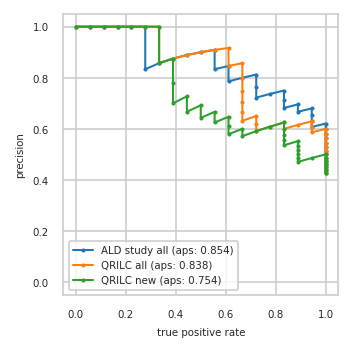

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all       QRILC all       QRILC new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.486 1.000
6          0.500 1.000     0.500 1.000     0.500 1.000
7          0.514 1.000     0.514 1.000     0.486 0.944
8          0.529 1.000     0.529 1.000     0.471 0.889
9          0.545 1.000     0.545 1.000     0.485 0.889
10         0.562 1.000     0.562 1.000     0.500 0.889
11         0.581 1.000     0.581 1.000     0.516 0.889
12         0.600 1.000     0.600 1.000     0.533 0.889
13         0.621 1.000     0.586 0.944     0.552 0.889
14         0.607 0.944     0.607 0.944     0.536 0.833
15         0.630 0.944     0.630 0.944     0.556 0.833
16         0.654 0.944     0.615 0.889     0.577 0.833
17         0.680 0.944     0.600 0.833     0.600 0.833
18         0.667 0.889     0.625 0.833     0.625 0.833
19         0.696 0.889     0.609 0.778     0.609 0.778
20         0.682 0.833     0.591 0.722     0.591 0.722
21         0.714 0.833     0.619 0.722     0.571 0.667
22         0.750 0.833     0.650 0.722     0.600 0.667
23         0.737 0.778     0.632 0.667     0.579 0.611
24         0.722 0.722     0.667 0.667     0.611 0.611
25         0.765 0.722     0.706 0.667     0.647 0.611
26         0.812 0.722     0.750 0.667     0.625 0.556
27         0.800 0.667     0.800 0.667     0.667 0.556
28         0.786 0.611     0.857 0.667     0.643 0.500
29         0.846 0.611     0.846 0.611     0.692 0.500
30         0.833 0.556     0.917 0.611     0.667 0.444
31         0.909 0.556     0.909 0.556     0.727 0.444
32         0.900 0.500     0.900 0.500     0.700 0.389
33         0.889 0.444     0.889 0.444     0.778 0.389
34         0.875 0.389     0.875 0.389     0.875 0.389
35         0.857 0.333     0.857 0.333     0.857 0.333
36         0.833 0.278     1.000 0.333     1.000 0.333
37         1.000 0.278     1.000 0.278     1.000 0.278
38         1.000 0.222     1.000 0.222     1.000 0.222
39         1.000 0.167     1.000 0.167     1.000 0.167
40         1.000 0.111     1.000 0.111     1.000 0.111
41         1.000 0.056     1.000 0.056     1.000 0.056
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve_train.pdf


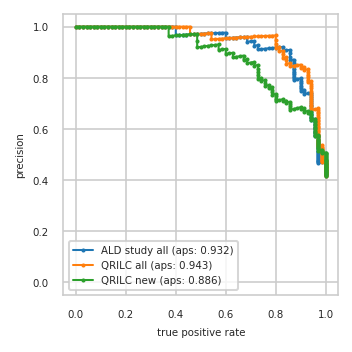

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve_train.pdf


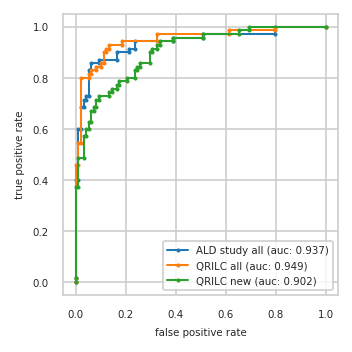

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_QRILC all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_QRILC all.pkl'),
 'results_QRILC new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_QRILC new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve_train.pdf')}